In [37]:
from qiskit import BasicAer

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType 
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

In [41]:
import numpy as np
import pylab

h2o = 'H; O 1 1.08; H 2 {} 1 104.5'
algorithms = ['VQE', 'ExactEigensolver']

pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
#distances = [x * 0.01 + 1.00 for x in range(17)]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print(i)
    for j in range(len(algorithms)):
        driver = PySCFDriver(h2o.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                                two_qubit_reduction=True, freeze_core=True)
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'ExactEigensolver':
            #result = ExactEigensolver(qubit_op).run()
            result = ExactEigensolver(qubit_op, aux_operators=aux_ops).run()
        else:
            optimizer = SLSQP(maxiter=2500)
            init_state = HartreeFock(num_qubits=qubit_op.num_qubits, 
                                     num_orbitals=core._molecule_info['num_orbitals'],
                                     num_particles=core._molecule_info['num_particles'],
                                     qubit_mapping=core._qubit_mapping,
                                     two_qubit_reduction=core._two_qubit_reduction)
            var_form = UCCSD(num_qubits=qubit_op.num_qubits,
                             depth=1,
                             num_orbitals=core._molecule_info['num_orbitals'], 
                             num_particles=core._molecule_info['num_particles'],
                             qubit_mapping=core._qubit_mapping,
                             two_qubit_reduction=core._two_qubit_reduction, 
                             initial_state=init_state)
            algo = VQE(qubit_op, var_form, optimizer)
            result = algo.run(quantum_instance)
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        if algorithms[j] == 'VQE':
            eval_counts[i] = result['algorithm_retvals']['eval_count']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step __0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
 --- complete
Distances:  [0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]
Energies: [[-70.85026638 -72.13537892 -73.01077785 -73.61810837 -74.04437782
  -74.34557783 -74.55901665 -74.71021452 -74.81693134 -74.89163557
  -74.94311308 -74.9775751  -74.99944901 -75.01194059 -75.01742385
  -75.01132034 -74.99048895 -74.96506965 -74.94023762 -74.91848403
  -74.90086356 -74.88751939 -74.87797673]
 [-70.85032882 -72.13544911 -73.0108502  -73.61818079 -74.04444997
  -74.34565064 -74.55909138 -74.71029241 -74.81701354 -74.89172329
  -74.94320704 -74.97767613 -74.99955788 -75.01205799 -75.01755036
  -75.01147117 -74.99066302 -74.9652607  -74.94043559 -74.91867629
  -74.90103892 -74.88767022 -74.87809943]]
Hartree-Fock energies: [-70.82124852 -72.10404193 -72.97731386 -73.58269635 -74.00713059
 -74.30653774 -74.51816479 -74.66748087 -74.77220231 -74.844

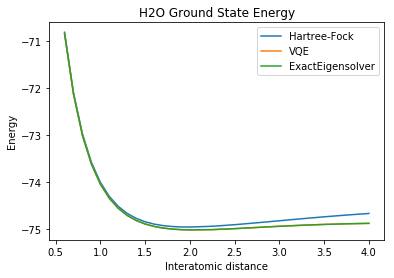

In [42]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2O Ground State Energy')
pylab.legend(loc='upper right');